### Model F - LSTM action sequence prediction  - PyTorch

### Imports

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

from sklearn.preprocessing import MinMaxScaler

### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

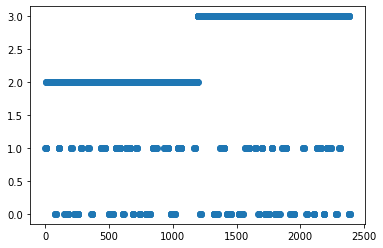

In [4]:
actions = oracle_reversed_data["actions"]
actions = [[i] for i in actions]

plt.plot(actions, "o")
plt.show()

### Preprocess and split dataset

In [130]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data


def create_data(seq_length, data, shuffle=True):

    actions = data["actions"]
    actions = [[i] for i in actions]
    training_data = actions

    x, y = sliding_windows(training_data, seq_length)

    # one method of performing the training and validation split
    train_size = int(len(y) * 0.80)
    test_size = len(y) - train_size

    # shuffle data first before splitting
    if shuffle:
        idx_shuf = list(range(len(y)))
        random.shuffle(idx_shuf)
        x = [x[i] for i in idx_shuf]
        y = [y[i] for i in idx_shuf]

    # split data
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))

    return trainX, trainY, testX, testY


training_data = actions


seq_length = 20
shuffle = False

x, y = sliding_windows(training_data, seq_length)

# one method of performing the training and validation split
train_size = int(len(y) * 0.80)
test_size = len(y) - train_size


# shuffle data first before splitting
if shuffle:
    idx_shuf = list(range(len(y)))
    random.shuffle(idx_shuf)
    x = [x[i] for i in idx_shuf]
    y = [y[i] for i in idx_shuf]

# split data
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))

In [132]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out


num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 300
num_layers = 1

num_classes = 4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [133]:
value = 0

test_input = trainX[value : value + 1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

outputs = lstm(test_input)
print(outputs)

print("outputs:", outputs)
_, rounded_opt = torch.max(outputs, 1)
print("output rounded:", rounded_opt)
print("labels:", trainY[value : value + 1])

print("")

outputs = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(outputs))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (1908, 1, 1), device="cpu"))

input length: 20
input (trainX): tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.]]])
tensor([[-0.0315, -0.0246, -0.0625, -0.0038]], grad_fn=<AddmmBackward0>)
outputs: tensor([[-0.0315, -0.0246, -0.0625, -0.0038]], grad_fn=<AddmmBackward0>)
output rounded: tensor([3])
labels: tensor([[2.]])

length input (trainX): 1895
length outputs: 1895
length labels: 1895

SUMMARY LSTM 
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1908, 4]                 --
├─LSTM: 1-1                              [1908, 1, 300]            363,600
├─Linear: 1-2                            [1908, 4]                 1,204
Total params: 364,804
Trainable params: 364,804
Non-trainable params: 0
Total mul

In [134]:
def plot_losses(test_loss, train_loss, num_epochs):

    for i in range(len(train_loss)):
        train_loss[i] = train_loss[i].item()

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    with plt.style.context("seaborn-darkgrid"):

        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="red", linewidth=2, label="Validation Loss")
        plt.plot(train_loss, color="slategray", linewidth=2, label="Training Loss")
        plt.legend(fontsize=font)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")

        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()


def plot_euclidean_distance(train_dis, test_dis, num_epochs):

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c="indianred", label="Validation", linewidth=3)
        plt.title("Difficult Environment", fontsize=font)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Accuracy", fontsize=font, **hfont)

        plt.xlim(xmax=num_epochs + 5, xmin=-5)

        # plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")

        plt.show()

### Train model with different lr.

learning rate is  0.01
Epoch: 0, train loss: 1.38587, train acc: 0.25777, test loss: 1.38638, test acc: 0.24664
Epoch: 25, train loss: 1.31134, train acc: 0.37615, test loss: 1.32324, test acc: 0.37081
Epoch: 50, train loss: 1.13844, train acc: 0.41268, test loss: 1.18854, test acc: 0.36913
Epoch: 75, train loss: 0.84991, train acc: 0.68304, test loss: 0.92737, test acc: 0.62584
Epoch: 100, train loss: 0.66814, train acc: 0.71830, test loss: 0.73744, test acc: 0.68792
Epoch: 125, train loss: 0.71304, train acc: 0.70865, test loss: 0.82605, test acc: 0.66611
Epoch: 150, train loss: 0.55431, train acc: 0.74307, test loss: 0.66442, test acc: 0.71309
Epoch: 175, train loss: 0.45254, train acc: 0.80143, test loss: 0.62784, test acc: 0.72987
Epoch: 200, train loss: 0.60710, train acc: 0.72880, test loss: 0.70876, test acc: 0.68792
Epoch: 225, train loss: 0.47365, train acc: 0.78212, test loss: 0.60245, test acc: 0.70805
Epoch: 250, train loss: 0.40513, train acc: 0.82116, test loss: 0.58545,

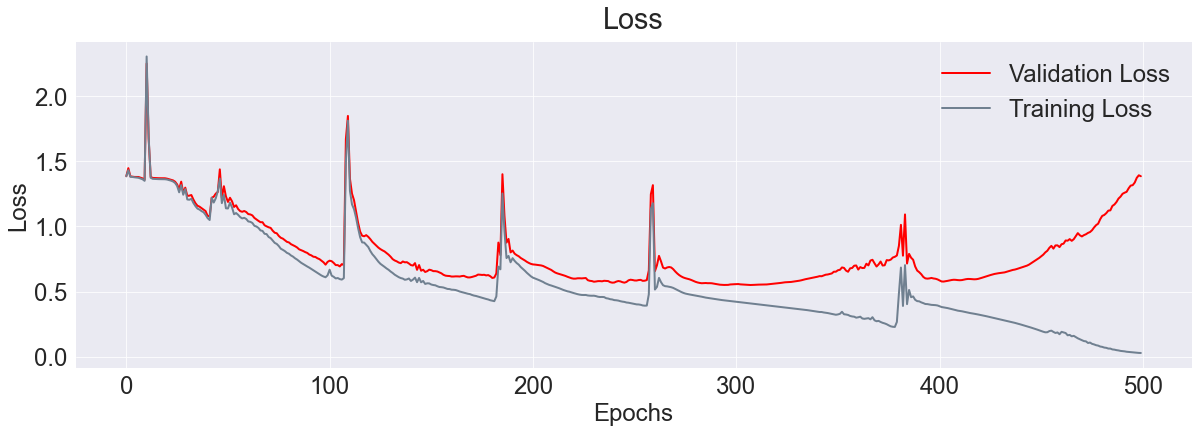

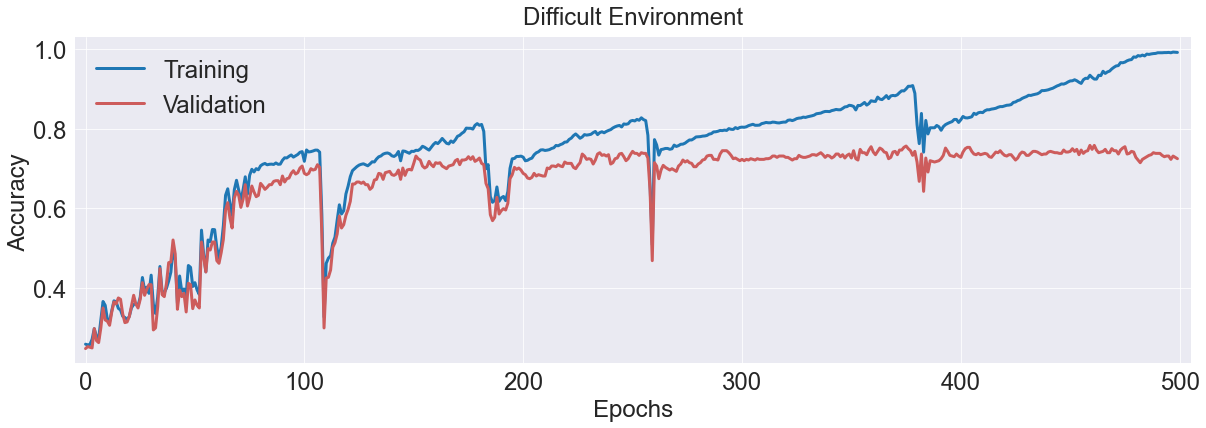

learning rate is  0.001
Epoch: 0, train loss: 1.38602, train acc: 0.28589, test loss: 1.38574, test acc: 0.27181
Epoch: 25, train loss: 1.34189, train acc: 0.35432, test loss: 1.35727, test acc: 0.33389
Epoch: 50, train loss: 1.27376, train acc: 0.39547, test loss: 1.29829, test acc: 0.39430
Epoch: 75, train loss: 1.02178, train acc: 0.51847, test loss: 1.08115, test acc: 0.49161
Epoch: 100, train loss: 0.87041, train acc: 0.61881, test loss: 0.94204, test acc: 0.59060
Epoch: 125, train loss: 0.79022, train acc: 0.67086, test loss: 0.87649, test acc: 0.65772
Epoch: 150, train loss: 0.88902, train acc: 0.62427, test loss: 0.97454, test acc: 0.60235
Epoch: 175, train loss: 0.75533, train acc: 0.66373, test loss: 0.85061, test acc: 0.62584
Epoch: 200, train loss: 0.71637, train acc: 0.72376, test loss: 0.81693, test acc: 0.70805
Epoch: 225, train loss: 0.68905, train acc: 0.73426, test loss: 0.79842, test acc: 0.71477
Epoch: 250, train loss: 0.66372, train acc: 0.74391, test loss: 0.78221

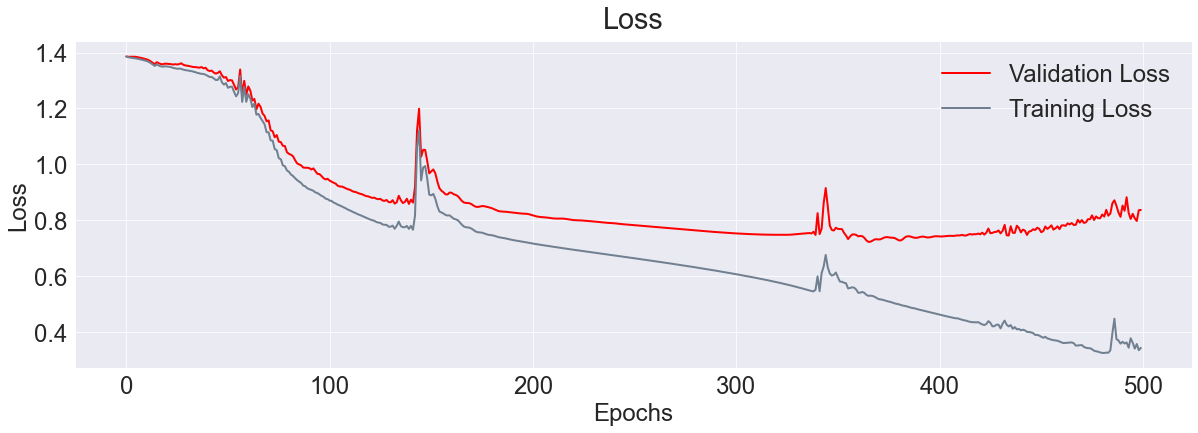

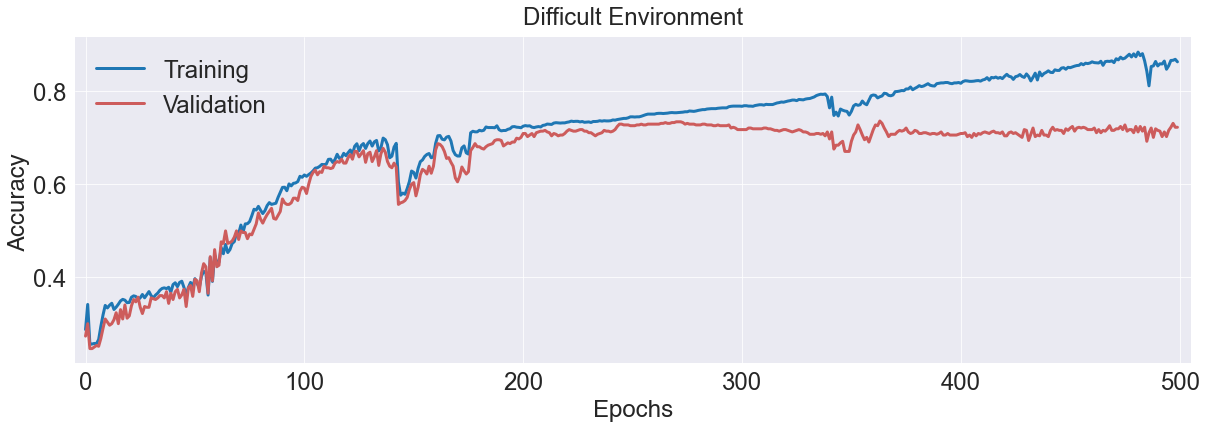

learning rate is  0.0001
Epoch: 0, train loss: 1.38837, train acc: 0.25315, test loss: 1.38700, test acc: 0.26846
Epoch: 25, train loss: 1.38188, train acc: 0.28589, test loss: 1.38416, test acc: 0.27013
Epoch: 50, train loss: 1.37792, train acc: 0.27792, test loss: 1.38216, test acc: 0.25671
Epoch: 75, train loss: 1.36612, train acc: 0.30269, test loss: 1.37151, test acc: 0.27517
Epoch: 100, train loss: 1.35279, train acc: 0.32536, test loss: 1.36423, test acc: 0.31879
Epoch: 125, train loss: 1.34852, train acc: 0.33921, test loss: 1.36318, test acc: 0.31376
Epoch: 150, train loss: 1.34285, train acc: 0.35013, test loss: 1.35928, test acc: 0.33221
Epoch: 175, train loss: 1.33192, train acc: 0.36482, test loss: 1.34830, test acc: 0.33725
Epoch: 200, train loss: 1.31425, train acc: 0.36230, test loss: 1.33363, test acc: 0.35570
Epoch: 225, train loss: 1.28690, train acc: 0.38959, test loss: 1.30773, test acc: 0.37248
Epoch: 250, train loss: 1.25440, train acc: 0.41058, test loss: 1.2715

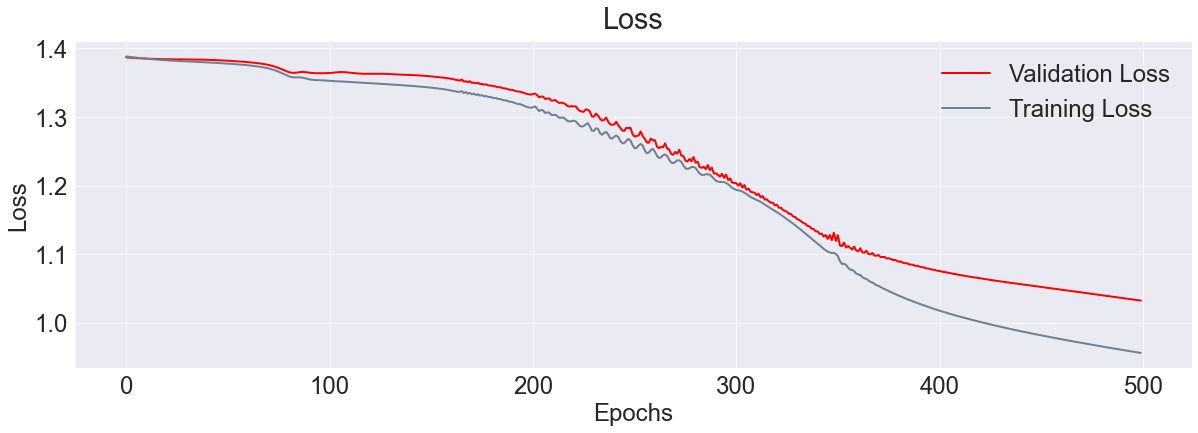

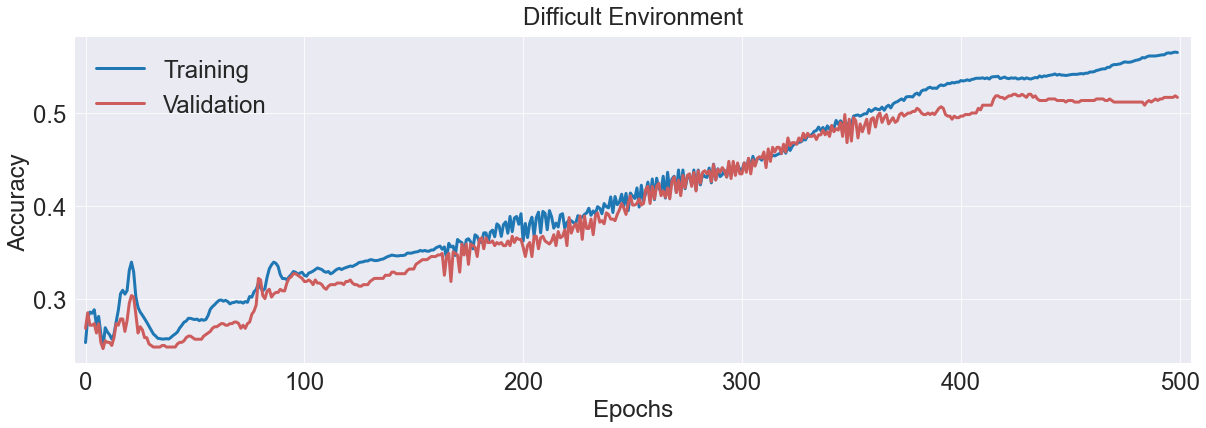

learning rate is  1e-05
Epoch: 0, train loss: 1.38876, train acc: 0.24601, test loss: 1.38822, test acc: 0.24329
Epoch: 25, train loss: 1.38791, train acc: 0.24601, test loss: 1.38773, test acc: 0.24329
Epoch: 50, train loss: 1.38716, train acc: 0.24601, test loss: 1.38731, test acc: 0.24329
Epoch: 75, train loss: 1.38650, train acc: 0.26406, test loss: 1.38696, test acc: 0.25839
Epoch: 100, train loss: 1.38591, train acc: 0.28212, test loss: 1.38665, test acc: 0.27685
Epoch: 125, train loss: 1.38537, train acc: 0.26742, test loss: 1.38638, test acc: 0.25000
Epoch: 150, train loss: 1.38488, train acc: 0.26238, test loss: 1.38614, test acc: 0.24497
Epoch: 175, train loss: 1.38441, train acc: 0.25945, test loss: 1.38591, test acc: 0.24497
Epoch: 200, train loss: 1.38397, train acc: 0.25987, test loss: 1.38567, test acc: 0.24497
Epoch: 225, train loss: 1.38354, train acc: 0.25987, test loss: 1.38544, test acc: 0.24329
Epoch: 250, train loss: 1.38310, train acc: 0.25735, test loss: 1.38519

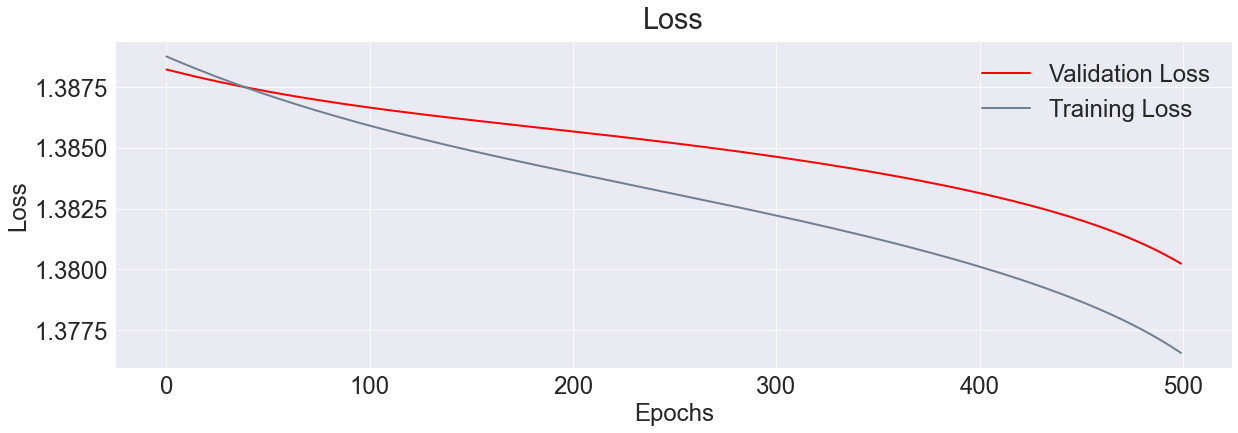

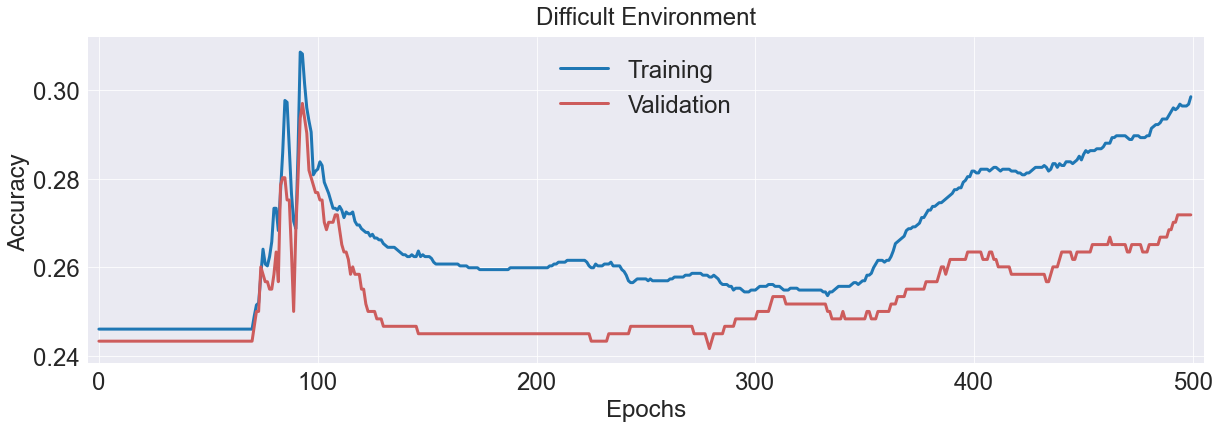

learning rate is  1e-06
Epoch: 0, train loss: 1.38688, train acc: 0.25777, test loss: 1.38658, test acc: 0.24664
Epoch: 25, train loss: 1.38681, train acc: 0.25777, test loss: 1.38655, test acc: 0.24664
Epoch: 50, train loss: 1.38674, train acc: 0.25777, test loss: 1.38652, test acc: 0.24664
Epoch: 75, train loss: 1.38667, train acc: 0.25777, test loss: 1.38649, test acc: 0.24664
Epoch: 100, train loss: 1.38660, train acc: 0.25777, test loss: 1.38646, test acc: 0.24664
Epoch: 125, train loss: 1.38654, train acc: 0.25777, test loss: 1.38643, test acc: 0.24664
Epoch: 150, train loss: 1.38647, train acc: 0.25777, test loss: 1.38640, test acc: 0.24664
Epoch: 175, train loss: 1.38641, train acc: 0.25777, test loss: 1.38637, test acc: 0.24664
Epoch: 200, train loss: 1.38634, train acc: 0.25777, test loss: 1.38634, test acc: 0.24664
Epoch: 225, train loss: 1.38628, train acc: 0.25777, test loss: 1.38632, test acc: 0.24664
Epoch: 250, train loss: 1.38622, train acc: 0.25777, test loss: 1.38629

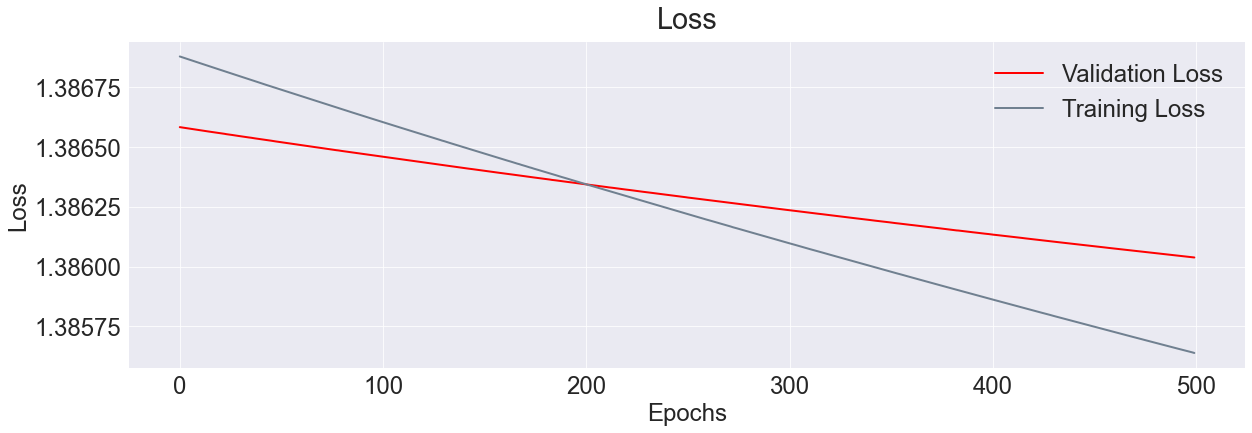

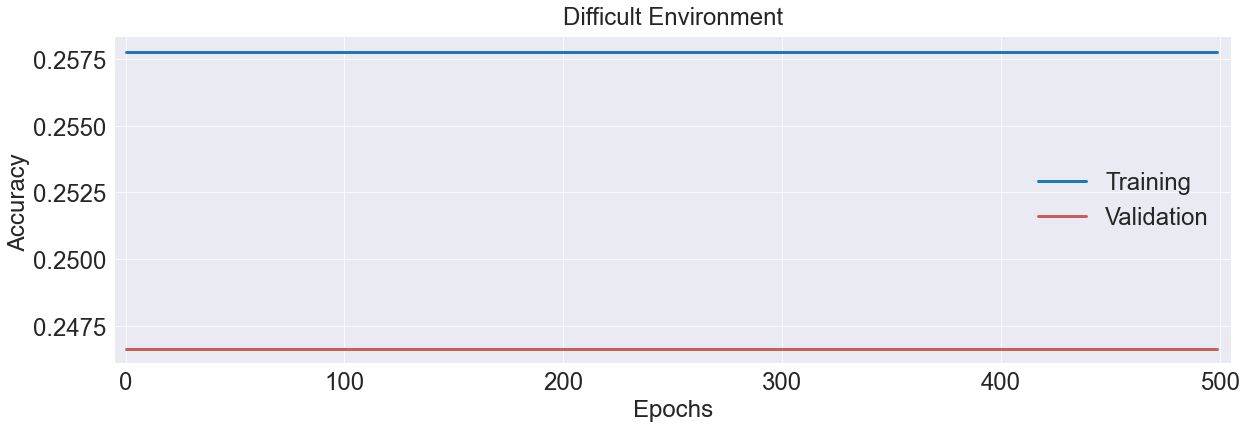

In [175]:
def train_lstm(num_epochs, trainX, trainY, testX, testY):

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    train_loss_collector = []
    train_acc_collector = []
    test_loss_collector = []
    test_acc_collector = []

    # Train the model
    for epoch in range(num_epochs):

        train_correct = 0
        train_total = 0

        optimizer.zero_grad()
        outputs = lstm(trainX)
        labels = trainY.to(torch.long)
        labels = labels[:, 0]
        loss = criterion(outputs, labels)
        loss.backward()

        # compute train acc
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_acc = correct / len(trainX)

        # test set
        with torch.no_grad():
            outputs = lstm(testX)
            labels = testY.to(torch.long)
            labels = labels[:, 0]
            loss_test = criterion(outputs, labels)

            # compute test acc
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            test_acc = correct / len(testX)

        train_loss_collector.append(loss)
        train_acc_collector.append(train_acc)
        test_loss_collector.append(loss_test)
        test_acc_collector.append(test_acc)

        optimizer.step()
        if epoch % (num_epochs / 20) == 0:
            print(
                "Epoch: %d, train loss: %1.5f, train acc: %1.5f, test loss: %1.5f, test acc: %1.5f"
                % (epoch, loss.item(), train_acc, loss_test.item(), test_acc)
            )
    return (
        train_loss_collector,
        train_acc_collector,
        test_loss_collector,
        test_acc_collector,
    )


data = oracle_reversed_random_data_small
trainX, trainY, testX, testY = create_data(seq_length, data, shuffle=True)


collect_acc_test = []
collect_acc_train = []
collect_loss_test = []
collect_loss_train = []

for i in range(1, 6):

    t = time.time()

    if i == 1:
        learning_rate = 0.01
    if i == 2:
        learning_rate = 0.001
    if i == 3:
        learning_rate = 0.0001
    if i == 4:
        learning_rate = 0.00001
    if i == 5:
        learning_rate = 0.000001

    hidden_size = 300
    num_epochs = 500

    print("learning rate is ", learning_rate)
    (
        train_loss_collector,
        train_acc_collector,
        test_loss_collector,
        test_acc_collector,
    ) = train_lstm(num_epochs, trainX, trainY, testX, testY)

    collect_acc_test.append(test_acc_collector)
    collect_acc_train.append(train_acc_collector)
    collect_loss_test.append(test_loss_collector)
    collect_loss_train.append(train_loss_collector)

    elapsed = time.time() - t
    print("############## ", elapsed, "  ##############")

    plot_losses(test_loss_collector, train_loss_collector, num_epochs)
    plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)

### Plot results for different lr.

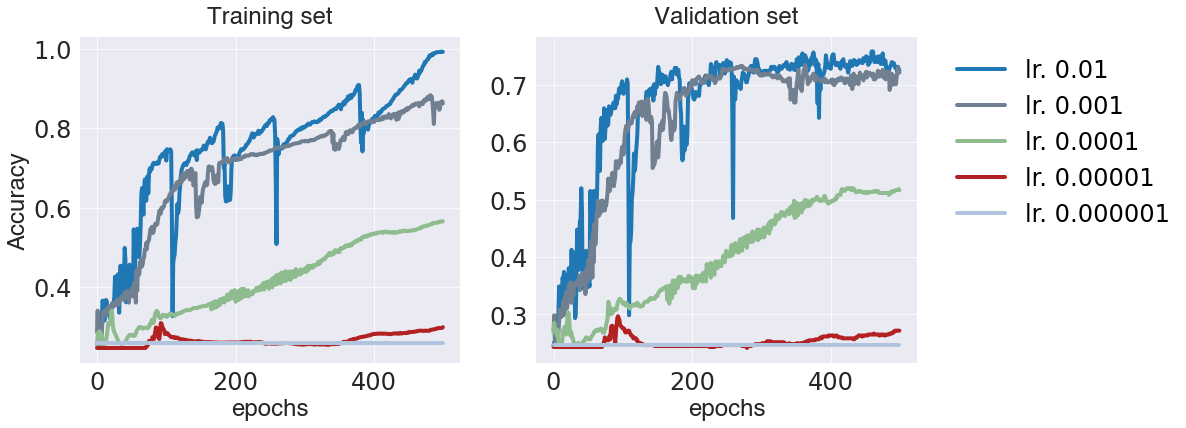

In [176]:
font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 2, 1)
    (y1,) = plt.plot(
        collect_acc_train[0],
        linestyle="solid",
        c="tab:blue",
        label="lr. 0.01",
        linewidth=4.0,
    )
    (y2,) = plt.plot(
        collect_acc_train[1],
        c="slategray",
        linestyle="solid",
        label="lr. 0.001",
        linewidth=4.0,
    )
    (y3,) = plt.plot(
        collect_acc_train[2],
        c="darkseagreen",
        linestyle="solid",
        label="lr. 0.0001",
        linewidth=4.0,
    )
    (y4,) = plt.plot(
        collect_acc_train[3],
        c="firebrick",
        linestyle="solid",
        label="lr. 0.00001",
        linewidth=4.0,
    )
    (y5,) = plt.plot(
        collect_acc_train[4],
        c="lightsteelblue",
        linestyle="solid",
        label="lr. 0.000001",
        linewidth=4.0,
    )

    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Training set", fontsize=font, **hfont)

    plt.subplot(1, 2, 2)
    plt.plot(
        collect_acc_test[0],
        linestyle="solid",
        c="tab:blue",
        label="Length 1",
        linewidth=4.0,
    )
    plt.plot(
        collect_acc_test[1],
        c="slategray",
        linestyle="solid",
        label="Length 9",
        linewidth=4.0,
    )
    plt.plot(
        collect_acc_test[2],
        c="darkseagreen",
        linestyle="solid",
        label="Length 17",
        linewidth=4.0,
    )
    plt.plot(
        collect_acc_test[3],
        c="firebrick",
        linestyle="solid",
        label="Length 17",
        linewidth=4.0,
    )
    plt.plot(
        collect_acc_test[4],
        c="lightsteelblue",
        linestyle="solid",
        label="Length 17",
        linewidth=4.0,
    )

    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Validation set", fontsize=font, **hfont)

plt.legend(
    handles=[y1, y2, y3, y4, y5],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
)
plt.savefig("lstm_action_pred_hidden_size.pdf", bbox_inches="tight")
plt.show()

### Train model on the different datasets


sequence lenth 1 easy environment
Epoch: 0, train loss: 1.35414, train acc: 0.40785, test loss: 1.35301, test acc: 0.44142
Epoch: 25, train loss: 0.61347, train acc: 0.87958, test loss: 0.62432, test acc: 0.88075
Epoch: 50, train loss: 0.51092, train acc: 0.87958, test loss: 0.54442, test acc: 0.88075
Epoch: 75, train loss: 0.40855, train acc: 0.87958, test loss: 0.43130, test acc: 0.88075
Epoch: 100, train loss: 0.33479, train acc: 0.94503, test loss: 0.35651, test acc: 0.93724
Epoch: 125, train loss: 0.31861, train acc: 0.94503, test loss: 0.34224, test acc: 0.93724
Epoch: 150, train loss: 0.28659, train acc: 0.94503, test loss: 0.30864, test acc: 0.93724
Epoch: 175, train loss: 0.24926, train acc: 0.94503, test loss: 0.27221, test acc: 0.93724
Epoch: 200, train loss: 0.23911, train acc: 0.94503, test loss: 0.26485, test acc: 0.93724
Epoch: 225, train loss: 0.23733, train acc: 0.94503, test loss: 0.26354, test acc: 0.93724
Epoch: 250, train loss: 0.23676, train acc: 0.94503, test lo

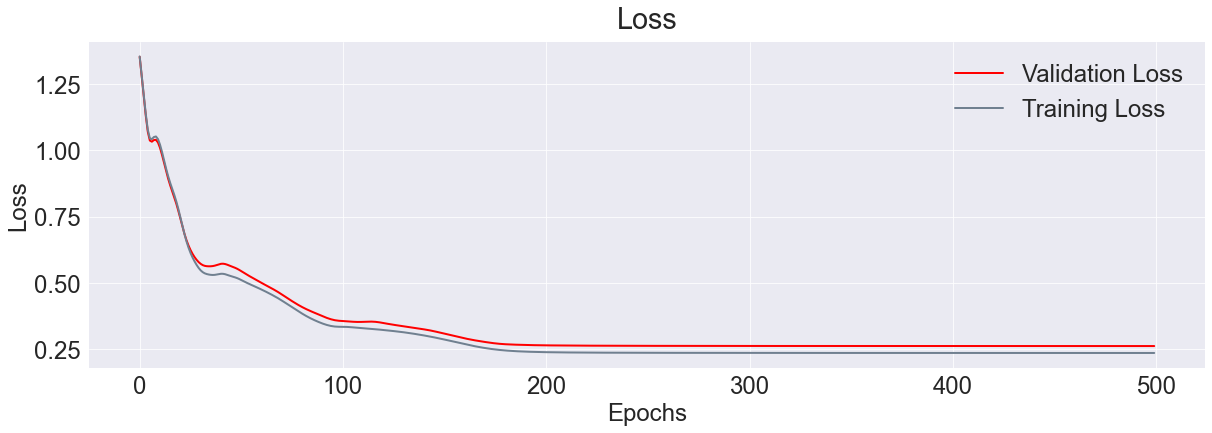

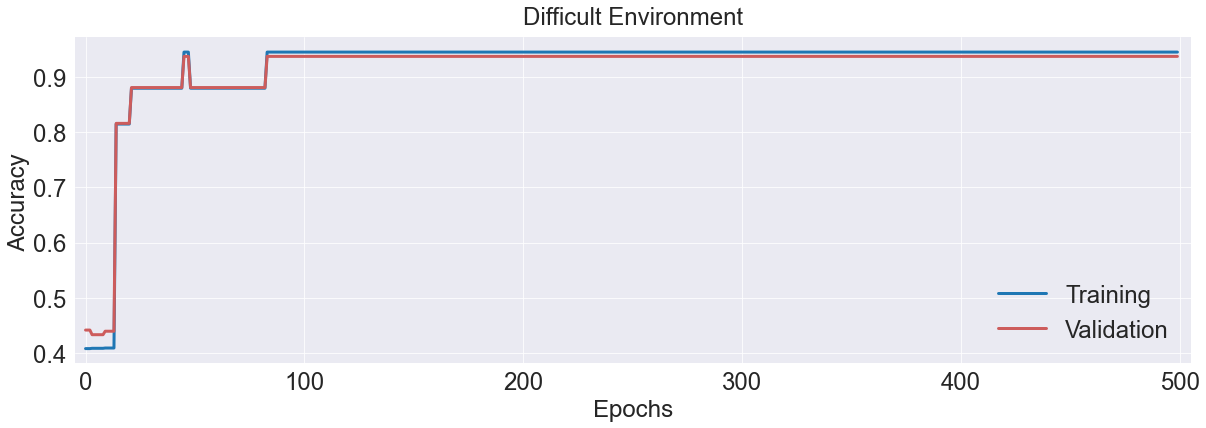


sequence lenth 11 easy environment
Epoch: 0, train loss: 1.36951, train acc: 0.41798, test loss: 1.36927, test acc: 0.40966
Epoch: 25, train loss: 0.92502, train acc: 0.46425, test loss: 0.91753, test acc: 0.43908
Epoch: 50, train loss: 0.46577, train acc: 0.85121, test loss: 0.44179, test acc: 0.86975
Epoch: 75, train loss: 0.21234, train acc: 0.95689, test loss: 0.20915, test acc: 0.95588
Epoch: 100, train loss: 0.20410, train acc: 0.95005, test loss: 0.20066, test acc: 0.94958
Epoch: 125, train loss: 0.16761, train acc: 0.95584, test loss: 0.18150, test acc: 0.95588
Epoch: 150, train loss: 0.18385, train acc: 0.95584, test loss: 0.17222, test acc: 0.96008
Epoch: 175, train loss: 0.16297, train acc: 0.96425, test loss: 0.16506, test acc: 0.96218
Epoch: 200, train loss: 0.15410, train acc: 0.97108, test loss: 0.15730, test acc: 0.96639
Epoch: 225, train loss: 0.19213, train acc: 0.96425, test loss: 0.20216, test acc: 0.96429
Epoch: 250, train loss: 0.15595, train acc: 0.96425, test l

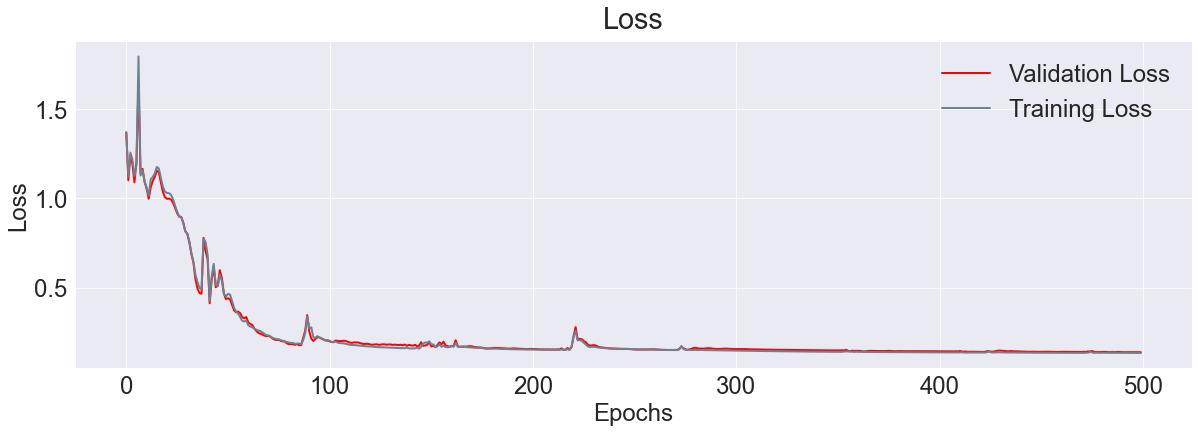

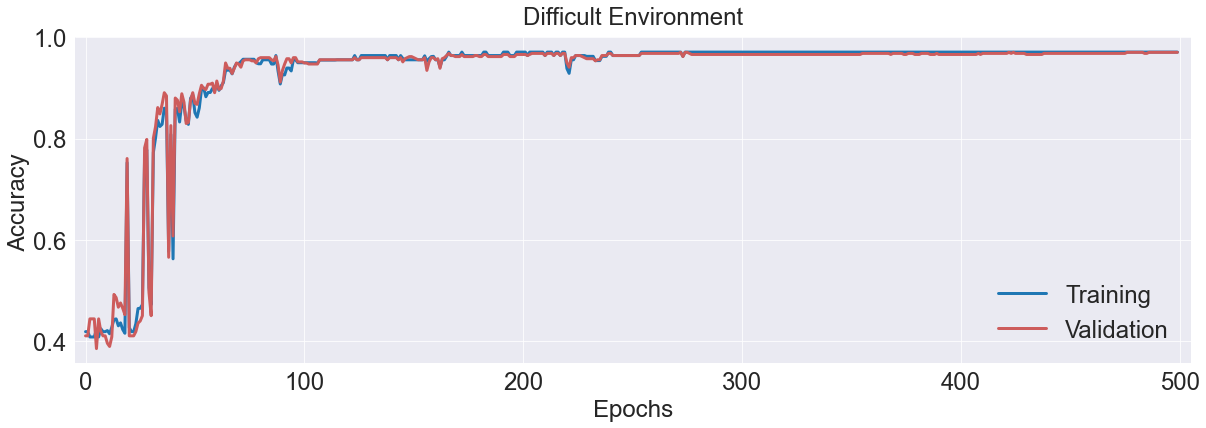


sequence lenth 21 easy environment
Epoch: 0, train loss: 1.37576, train acc: 0.42239, test loss: 1.37702, test acc: 0.40084
Epoch: 25, train loss: 0.97019, train acc: 0.54013, test loss: 0.96327, test acc: 0.53586
Epoch: 50, train loss: 0.26661, train acc: 0.91763, test loss: 0.26629, test acc: 0.90928
Epoch: 75, train loss: 0.22343, train acc: 0.93453, test loss: 0.21493, test acc: 0.93460
Epoch: 100, train loss: 0.17686, train acc: 0.95565, test loss: 0.16921, test acc: 0.95992
Epoch: 125, train loss: 0.48157, train acc: 0.90602, test loss: 0.48319, test acc: 0.89873
Epoch: 150, train loss: 0.21127, train acc: 0.94667, test loss: 0.19586, test acc: 0.95148
Epoch: 175, train loss: 0.16622, train acc: 0.95565, test loss: 0.15047, test acc: 0.95781
Epoch: 200, train loss: 0.54446, train acc: 0.92239, test loss: 0.53421, test acc: 0.90084
Epoch: 225, train loss: 0.22019, train acc: 0.95565, test loss: 0.20979, test acc: 0.95992
Epoch: 250, train loss: 0.25499, train acc: 0.95037, test l

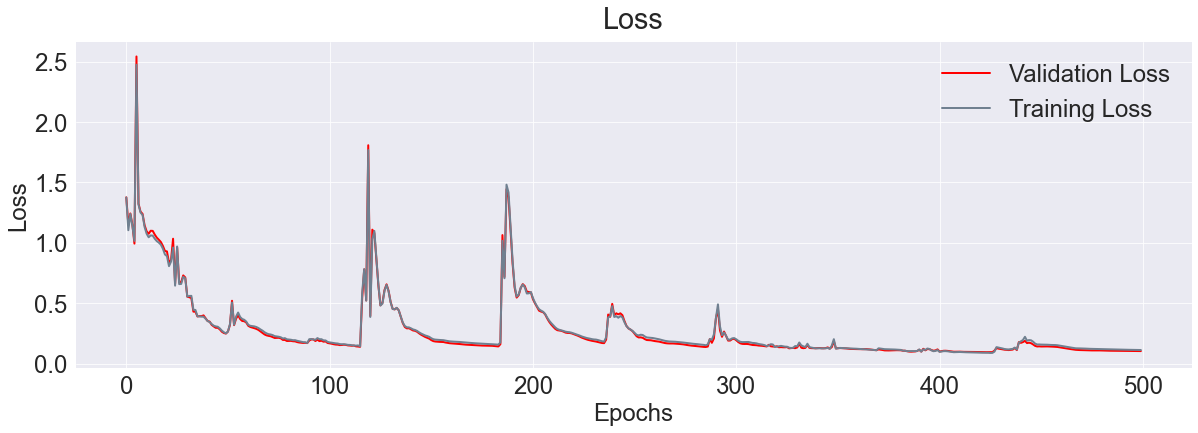

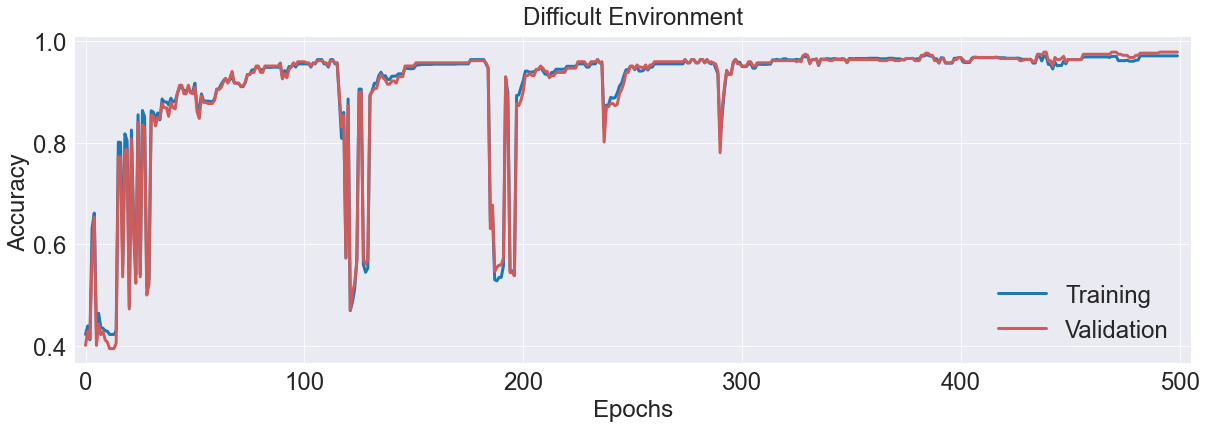


sequence lenth 1 medium environment
Epoch: 0, train loss: 1.38606, train acc: 0.26147, test loss: 1.38727, test acc: 0.22500
Epoch: 25, train loss: 1.32031, train acc: 0.47415, test loss: 1.33095, test acc: 0.45833
Epoch: 50, train loss: 1.29136, train acc: 0.39575, test loss: 1.29837, test acc: 0.41333
Epoch: 75, train loss: 1.26783, train acc: 0.47415, test loss: 1.27636, test acc: 0.45833
Epoch: 100, train loss: 1.24511, train acc: 0.47415, test loss: 1.25884, test acc: 0.45833
Epoch: 125, train loss: 1.24458, train acc: 0.47415, test loss: 1.25847, test acc: 0.45833
Epoch: 150, train loss: 1.24453, train acc: 0.47415, test loss: 1.25913, test acc: 0.45833
Epoch: 175, train loss: 1.24453, train acc: 0.47415, test loss: 1.25904, test acc: 0.45833
Epoch: 200, train loss: 1.24489, train acc: 0.47415, test loss: 1.26056, test acc: 0.45833
Epoch: 225, train loss: 1.24454, train acc: 0.47415, test loss: 1.25919, test acc: 0.45833
Epoch: 250, train loss: 1.24453, train acc: 0.47415, test 

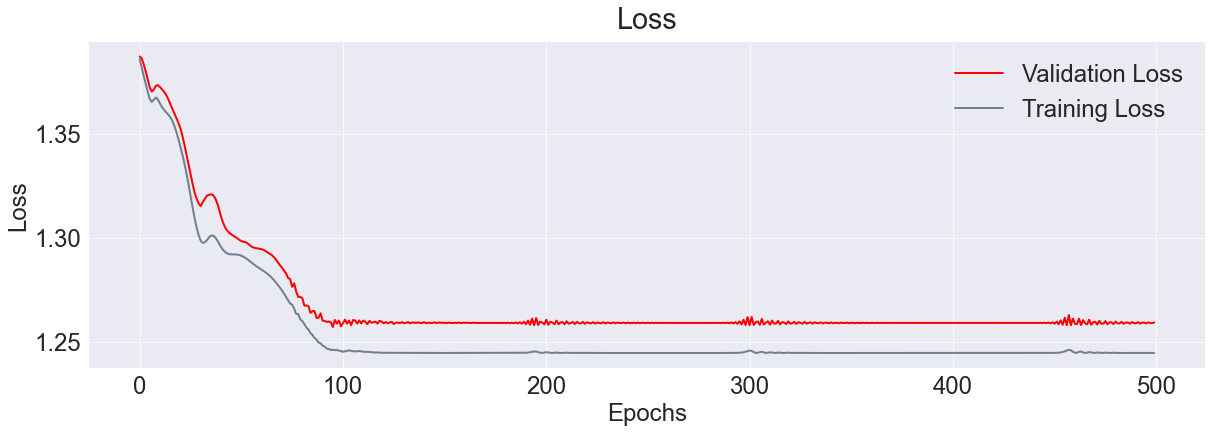

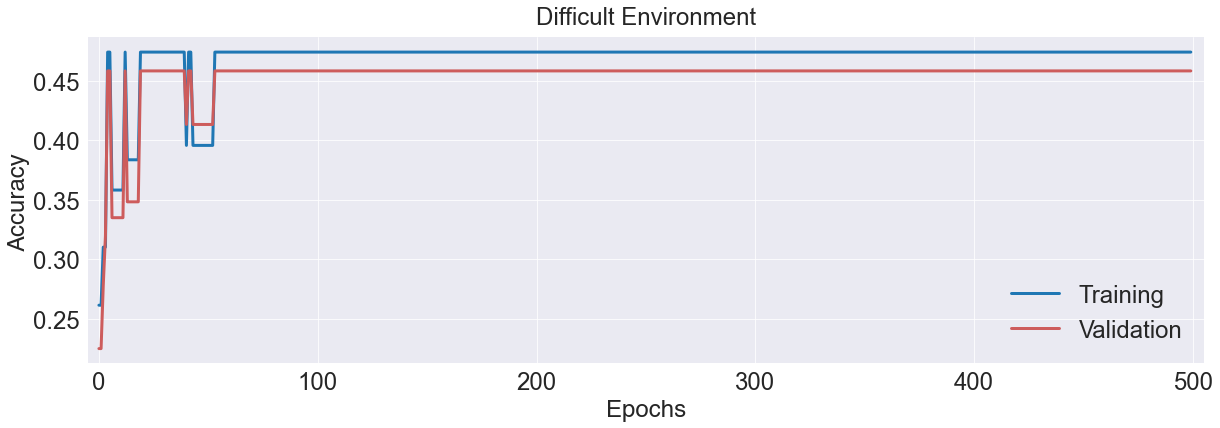


sequence lenth 11 medium environment
Epoch: 0, train loss: 1.38661, train acc: 0.26151, test loss: 1.38802, test acc: 0.22742
Epoch: 25, train loss: 1.14360, train acc: 0.41967, test loss: 1.11924, test acc: 0.45485
Epoch: 50, train loss: 0.81287, train acc: 0.64351, test loss: 0.78823, test acc: 0.66054
Epoch: 75, train loss: 0.63596, train acc: 0.72552, test loss: 0.60805, test acc: 0.73579
Epoch: 100, train loss: 0.85827, train acc: 0.58577, test loss: 1.00424, test acc: 0.53010
Epoch: 125, train loss: 0.52189, train acc: 0.77113, test loss: 0.56308, test acc: 0.74582
Epoch: 150, train loss: 0.39154, train acc: 0.82803, test loss: 0.63068, test acc: 0.73077
Epoch: 175, train loss: 0.32617, train acc: 0.84686, test loss: 0.74253, test acc: 0.73579
Epoch: 200, train loss: 0.27964, train acc: 0.86695, test loss: 0.90030, test acc: 0.73746
Epoch: 225, train loss: 0.27187, train acc: 0.87029, test loss: 0.99557, test acc: 0.72742
Epoch: 250, train loss: 0.24574, train acc: 0.87531, test

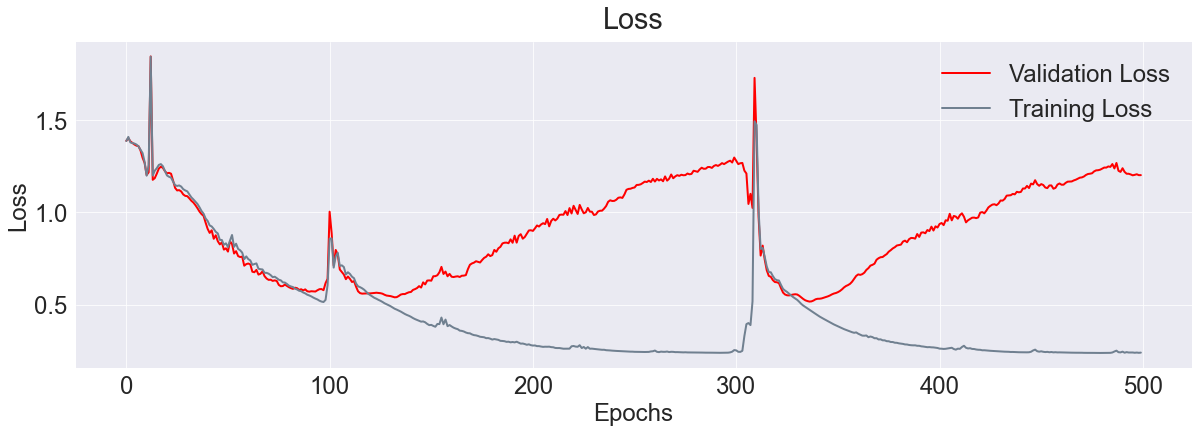

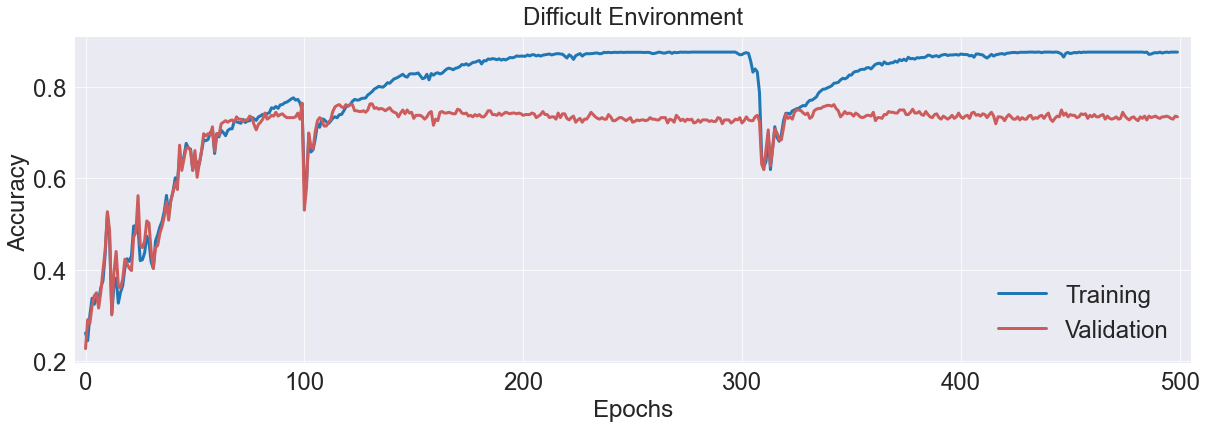


sequence lenth 21 medium environment
Epoch: 0, train loss: 1.38697, train acc: 0.22922, test loss: 1.38717, test acc: 0.21477
Epoch: 25, train loss: 1.33437, train acc: 0.33081, test loss: 1.33739, test acc: 0.31879
Epoch: 50, train loss: 1.00667, train acc: 0.60076, test loss: 1.00431, test acc: 0.59396
Epoch: 75, train loss: 0.73022, train acc: 0.69018, test loss: 0.73199, test acc: 0.69631
Epoch: 100, train loss: 0.51334, train acc: 0.76700, test loss: 0.57881, test acc: 0.73826
Epoch: 125, train loss: 1.52414, train acc: 0.45298, test loss: 1.59677, test acc: 0.43289
Epoch: 150, train loss: 0.58260, train acc: 0.72922, test loss: 0.61705, test acc: 0.70805
Epoch: 175, train loss: 0.64528, train acc: 0.71159, test loss: 0.67501, test acc: 0.68289
Epoch: 200, train loss: 0.46962, train acc: 0.78547, test loss: 0.53943, test acc: 0.74664
Epoch: 225, train loss: 0.39667, train acc: 0.80563, test loss: 0.52944, test acc: 0.74832
Epoch: 250, train loss: 0.37609, train acc: 0.82326, test

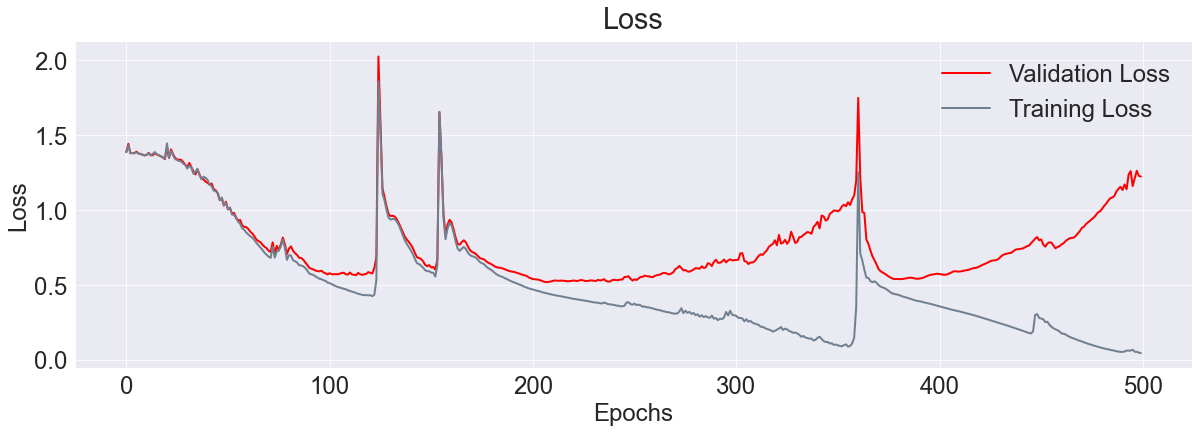

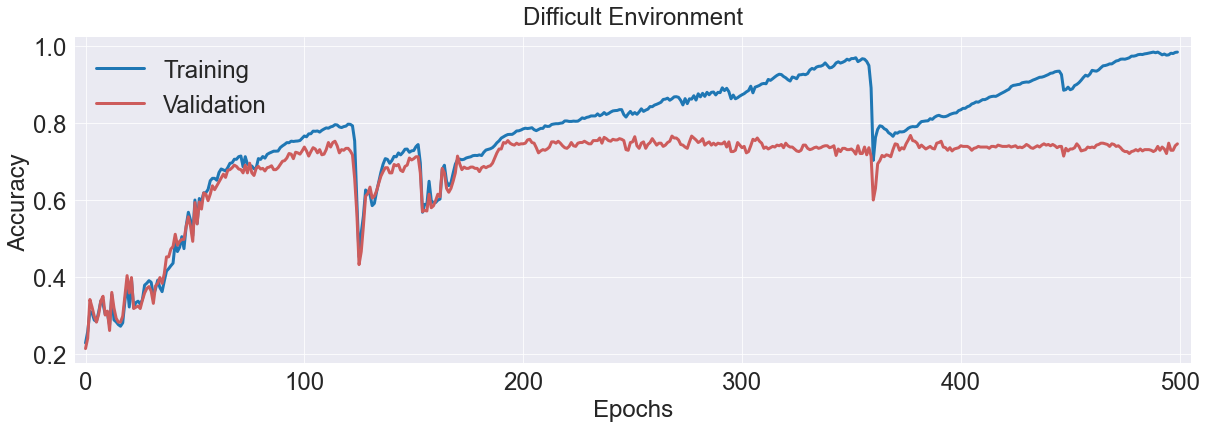


sequence lenth 1 difficult environment
Epoch: 0, train loss: 1.38643, train acc: 0.23905, test loss: 1.38621, test acc: 0.25250
Epoch: 25, train loss: 1.38449, train acc: 0.26596, test loss: 1.39005, test acc: 0.22750
Epoch: 50, train loss: 1.38411, train acc: 0.27284, test loss: 1.38797, test acc: 0.23000
Epoch: 75, train loss: 1.38361, train acc: 0.28223, test loss: 1.38920, test acc: 0.23250
Epoch: 100, train loss: 1.38302, train acc: 0.28223, test loss: 1.39262, test acc: 0.23250
Epoch: 125, train loss: 1.38286, train acc: 0.28223, test loss: 1.39260, test acc: 0.23250
Epoch: 150, train loss: 1.38285, train acc: 0.28223, test loss: 1.39275, test acc: 0.23250
Epoch: 175, train loss: 1.38285, train acc: 0.28223, test loss: 1.39281, test acc: 0.23250
Epoch: 200, train loss: 1.38285, train acc: 0.28223, test loss: 1.39280, test acc: 0.23250
Epoch: 225, train loss: 1.38285, train acc: 0.28223, test loss: 1.39280, test acc: 0.23250
Epoch: 250, train loss: 1.38285, train acc: 0.28223, te

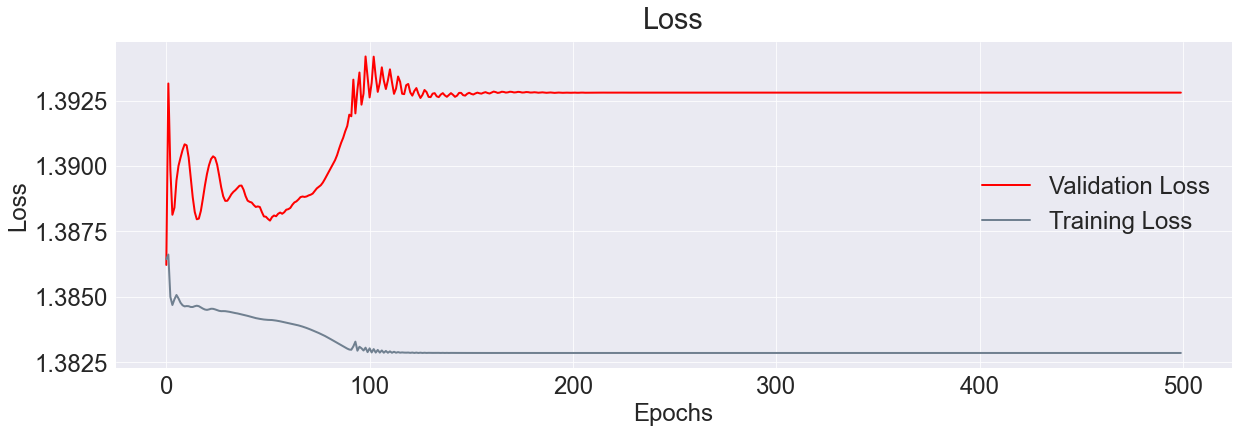

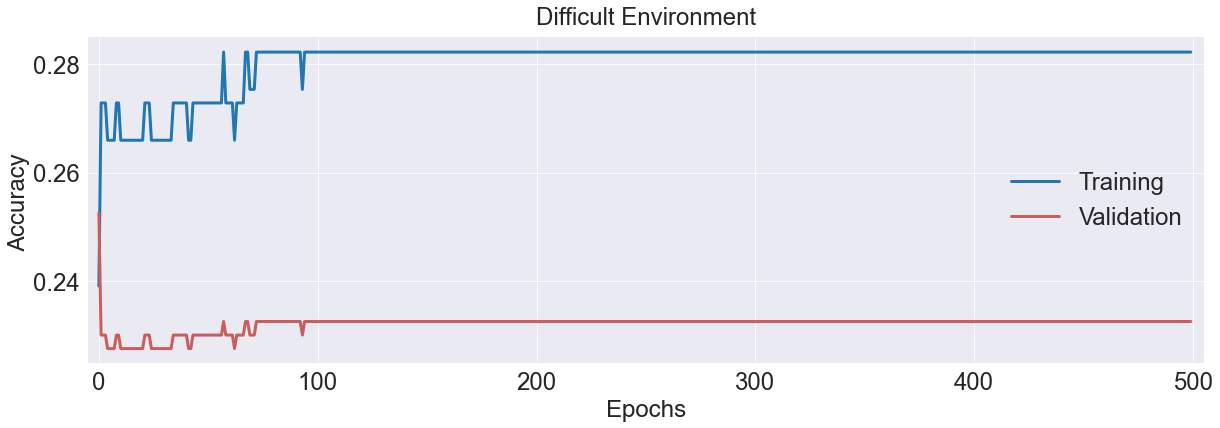


sequence lenth 11 difficult environment
Epoch: 0, train loss: 1.38642, train acc: 0.24717, test loss: 1.38800, test acc: 0.24623
Epoch: 25, train loss: 1.39173, train acc: 0.25535, test loss: 1.39135, test acc: 0.27136
Epoch: 50, train loss: 1.37829, train acc: 0.28239, test loss: 1.39097, test acc: 0.25126
Epoch: 75, train loss: 1.36507, train acc: 0.30189, test loss: 1.39725, test acc: 0.25126
Epoch: 100, train loss: 1.34642, train acc: 0.32893, test loss: 1.40469, test acc: 0.28141
Epoch: 125, train loss: 1.31527, train acc: 0.36667, test loss: 1.43674, test acc: 0.27387
Epoch: 150, train loss: 1.25688, train acc: 0.42075, test loss: 1.51975, test acc: 0.24121
Epoch: 175, train loss: 1.18575, train acc: 0.46101, test loss: 1.60358, test acc: 0.25377
Epoch: 200, train loss: 0.87296, train acc: 0.64465, test loss: 1.84566, test acc: 0.26131
Epoch: 225, train loss: 0.28499, train acc: 0.91950, test loss: 2.62212, test acc: 0.26131
Epoch: 250, train loss: 0.01112, train acc: 1.00000, t

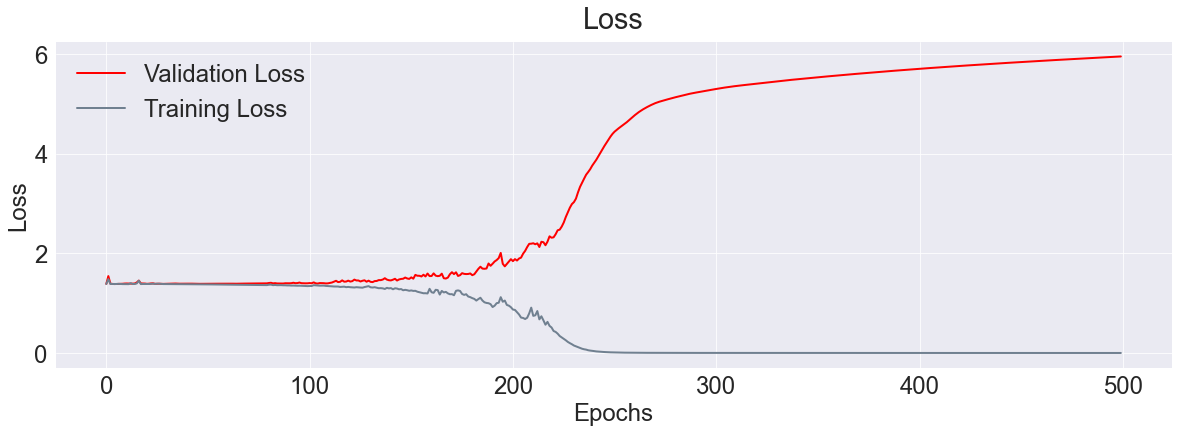

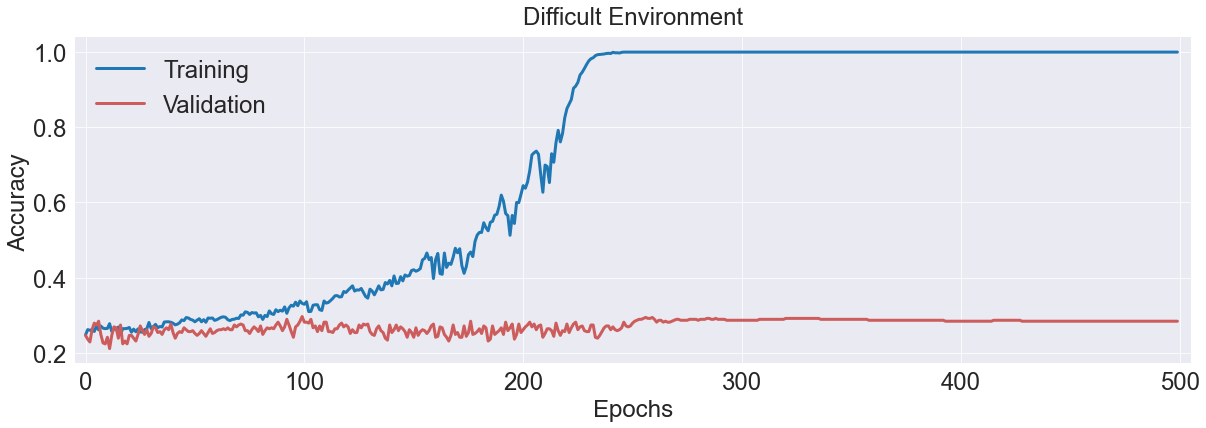


sequence lenth 21 difficult environment
Epoch: 0, train loss: 1.38653, train acc: 0.25917, test loss: 1.38529, test acc: 0.27525
Epoch: 25, train loss: 1.44393, train acc: 0.25284, test loss: 1.46385, test acc: 0.19697
Epoch: 50, train loss: 1.38612, train acc: 0.26043, test loss: 1.39061, test acc: 0.24495
Epoch: 75, train loss: 1.38556, train acc: 0.26043, test loss: 1.38735, test acc: 0.24495
Epoch: 100, train loss: 1.38525, train acc: 0.25537, test loss: 1.38773, test acc: 0.24747
Epoch: 125, train loss: 1.38515, train acc: 0.26359, test loss: 1.38761, test acc: 0.28283
Epoch: 150, train loss: 1.38493, train acc: 0.26485, test loss: 1.38776, test acc: 0.27020
Epoch: 175, train loss: 1.38311, train acc: 0.27370, test loss: 1.38450, test acc: 0.28030
Epoch: 200, train loss: 1.38033, train acc: 0.28003, test loss: 1.38511, test acc: 0.25758
Epoch: 225, train loss: 1.37174, train acc: 0.29899, test loss: 1.38945, test acc: 0.25505
Epoch: 250, train loss: 1.35837, train acc: 0.32048, t

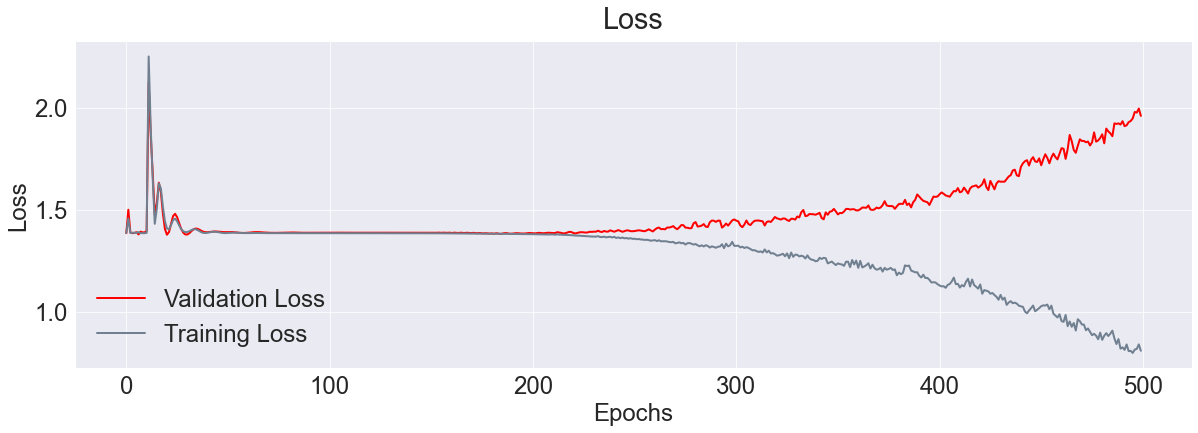

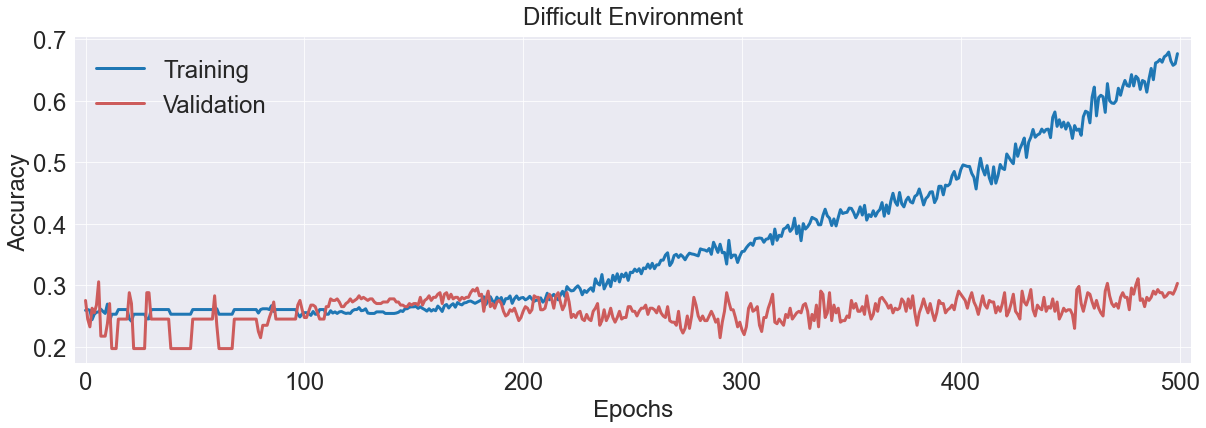

In [138]:
def run_all_environments(environments):

    meta_meta_train_acc_collector = []
    meta_meta_test_acc_collector = []

    for idx, data in enumerate(environments):

        num_epochs = 500
        learning_rate = 0.0001

        input_size = 1
        hidden_size = 300
        num_layers = 1

        num_classes = 4

        meta_train_acc_collector = []
        meta_test_acc_collector = []

        for i in range(1, 22, 10):

            print("")
            if idx == 0:
                print("sequence lenth", i, "easy environment")
            if idx == 1:
                print("sequence lenth", i, "medium environment")
            if idx == 2:
                print("sequence lenth", i, "difficult environment")
            seq_length = i
            shuffle = True

            trainX, trainY, testX, testY = create_data(seq_length, data, shuffle=True)

            (
                train_loss_collector,
                train_acc_collector,
                test_loss_collector,
                test_acc_collector,
            ) = train_lstm(num_epochs, trainX, trainY, testX, testY)

            plot_losses(test_loss_collector, train_loss_collector, num_epochs)
            plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)

            meta_train_acc_collector.append(train_acc_collector)
            meta_test_acc_collector.append(test_acc_collector)

        meta_meta_train_acc_collector.append(meta_train_acc_collector)
        meta_meta_test_acc_collector.append(meta_test_acc_collector)

    return meta_meta_train_acc_collector, meta_meta_test_acc_collector


environments = [
    oracle_reversed_data,
    oracle_reversed_random_data_small,
    tmaze_random_reverse_data,
]

# 3 environments x 3 sequence lenghts x actual runs
train_distances, test_distances = run_all_environments(environments)

### Plot results for the different datasets

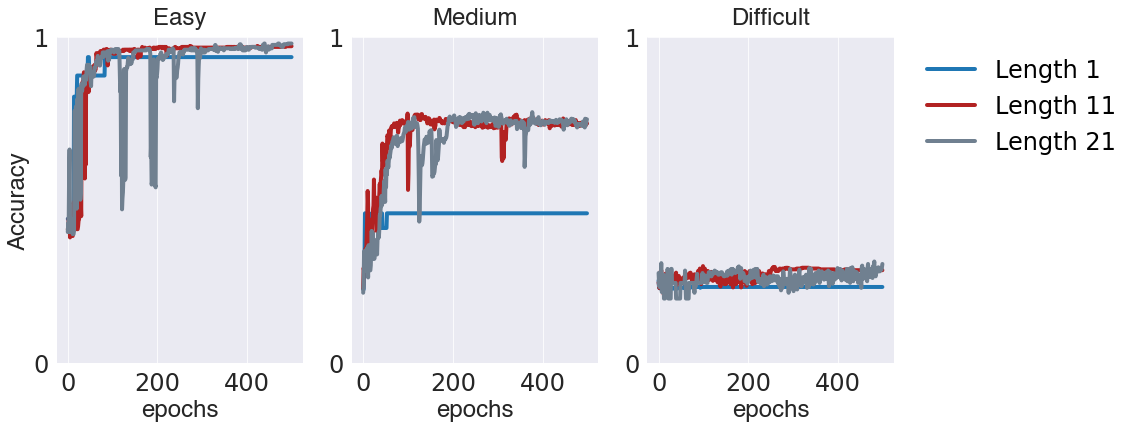

In [140]:
font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    (y1,) = plt.plot(
        test_distances[0][0],
        linestyle="solid",
        c="tab:blue",
        label="Length 1",
        linewidth=4.0,
    )
    (y2,) = plt.plot(
        test_distances[0][1],
        c="firebrick",
        linestyle="solid",
        label="Length 11",
        linewidth=4.0,
    )
    (y3,) = plt.plot(
        test_distances[0][2],
        c="slategray",
        linestyle="solid",
        label="Length 21",
        linewidth=4.0,
    )

    # plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax=1, ymin=0)
    plt.yticks(np.arange(0, 1 + 0.1, 1))
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)

    plt.subplot(1, 3, 2)
    plt.plot(
        test_distances[1][0],
        linestyle="solid",
        c="tab:blue",
        label="Length 1",
        linewidth=4.0,
    )
    plt.plot(
        test_distances[1][1],
        c="firebrick",
        linestyle="solid",
        label="Length 9",
        linewidth=4.0,
    )
    plt.plot(
        test_distances[1][2],
        c="slategray",
        linestyle="solid",
        label="Length 17",
        linewidth=4.0,
    )

    # plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax=1, ymin=0)
    plt.yticks(np.arange(0, 1 + 0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    plt.subplot(1, 3, 3)
    plt.plot(
        test_distances[2][0],
        linestyle="solid",
        c="tab:blue",
        label="Length 1",
        linewidth=4.0,
    )
    plt.plot(
        test_distances[2][1],
        c="firebrick",
        linestyle="solid",
        label="Length 9",
        linewidth=4.0,
    )
    plt.plot(
        test_distances[2][2],
        c="slategray",
        linestyle="solid",
        label="Length 17",
        linewidth=4.0,
    )

    # plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax=1, ymin=0)
    plt.yticks(np.arange(0, 1 + 0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)

plt.legend(
    handles=[y1, y2, y3], bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False
)
plt.savefig("lstm_action_pred_test_shuffle_True.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plot_losses(test_loss_collector, train_loss_collector, num_epochs)
plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)

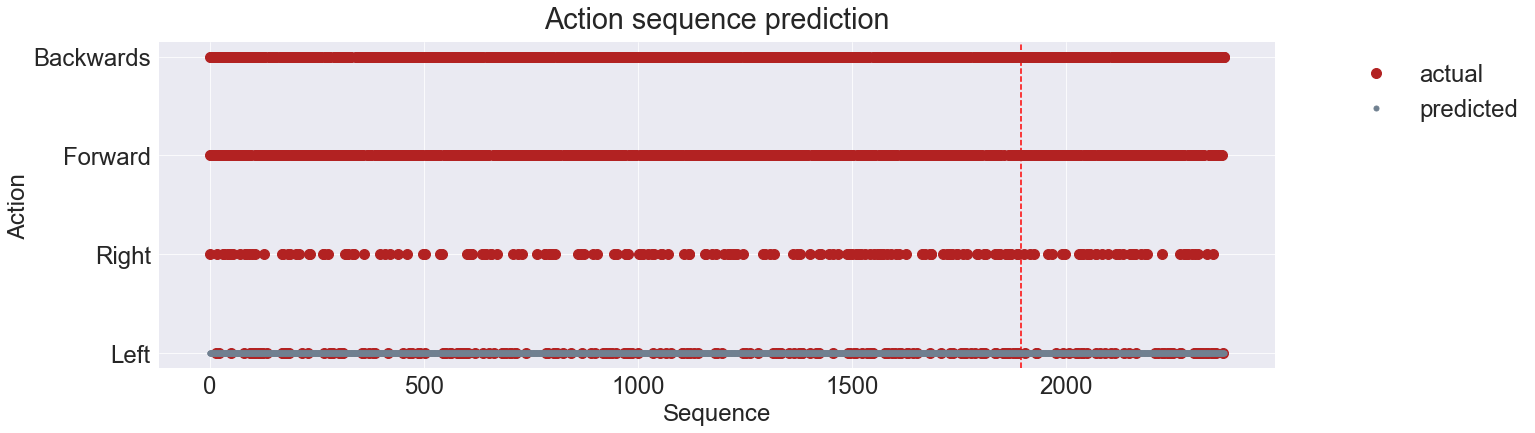

In [120]:
# test with medium environmnet length 10

actions = oracle_reversed_random_data_small["actions"]


lstm.eval()
predict = lstm(dataX)  # all data

_, predicted = torch.max(predict, 1)
data_predict = predicted.data.numpy()

dataY_plot = dataY.data.numpy()

font = 24
hfont = {"fontname": "Helvetica"}

plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"
plt.rcParams.update({"font.size": 24})

with plt.style.context("seaborn-darkgrid"):
    plt.figure(figsize=(20, 6))

    plt.axvline(x=train_size, c="r", linestyle="--")

    plt.plot(dataY_plot, "o", color="firebrick", markersize=10, label="actual")
    plt.plot(data_predict, "o", color="slategray", markersize=5, label="predicted")

    plt.yticks([0, 1, 2, 3], ["Left", "Right", "Forward", "Backwards"])

    # plt.legend(['Training Acc', 'Validation Acc'])
    # plt.legend(loc="lower right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("Action sequence prediction")
    plt.xlabel("Sequence", fontsize=font, **hfont)
    plt.ylabel("Action", fontsize=font, **hfont)
    plt.show()